In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTEENN
import warnings
from IPython.display import display, Markdown
warnings.filterwarnings("ignore")


In [3]:
def transform_x(x_df, enc):
    """
    Build min max scaler/one hot encoder from scikit learn
    """
    x_enc = enc.transform(x_df)
    feature_names = enc.get_feature_names_out(x_df.columns)
    x_enc_df = pd.DataFrame(x_enc, columns=feature_names)
    return x_enc_df

def preprocess_x(x_df, enc, scaler):
    """
    one hot encode categorical variable using enc given
    scale numeric variable using scaler given
    combine the 2 datasets
    """
    cat_x_df = transform_x(x_df[CAT_VAR], enc)

    num_x_df = transform_x(x_df[NUMERIC_VAR], scaler)
    final_x_df = pd.concat([cat_x_df, num_x_df], axis = 1).reset_index(drop=True)
    return final_x_df

def scoring(y_true, y_pred):
    """
    Calculate metrics given predicted labels and ground truth labels
    """
    recall = round(recall_score(y_true, y_pred)*100,2)
    precision = round(precision_score(y_true, y_pred)*100,2)
    roc_auc = round(roc_auc_score(y_true, y_pred),4)
    results = [[recall, f'{recall:.2f}% of all real fraud cases are detected.'],
              [precision, f'{precision:.2f}% of all predicted cases are correct.'],
              [roc_auc, f'{roc_auc*100:.2f}% of the time the model can distinguish positive from negative']]
    results_df = pd.DataFrame(results, columns=['value','Intepretation'])
    return results_df

# currently not using
def get_threshold_for_fixed_fpr(y_test, y_pred, fixed_fpr=0.9):
    """
    get threshold given a fixed fpr (currently not using)
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=False)
    display(pd.DataFrame([fpr, tpr, thresholds], columns=['fpr', 'tpr', 'thresholds']))
    idx = np.argmax(fpr > fixed_fpr)
    return thresholds[idx]

def grid_search_cv(params, k, datax, datay, weights=None):
    """
    Implement grid search with kfold cross validation for logistic regression 
    precision, recall, auc calculated
    """
    results = []
    for c in params:
        cresult= {'recall': 0, 'precision':0, 'auc':0, 'C':c}
        kf = KFold(n_splits=k, shuffle=True, random_state=SEED)
        for i, (train_index, test_index) in enumerate(kf.split(datax)):
            # split dataset
            t_X, v_X = datax.iloc[train_index,:], datax.iloc[test_index,:]
            t_y, v_y = datay.iloc[train_index], datay.iloc[test_index]
            # Train
            lg = LogisticRegression(random_state=SEED, class_weight=weights, n_jobs=3, C=c, max_iter=10000)
            lg.fit(t_X, t_y)
            # Test
            val_probs = lg.predict_proba(v_X)
            v_y_pred = val_probs[:,1] > THRESHOLD
            # metrics calculation
            result = scoring(v_y , v_y_pred)
            cresult['precision'] += result['precision'] / k
            cresult['recall'] += result['recall'] / k
            cresult['auc'] += result['auc'] / k
        results.append(cresult)
    results_df = pd.DataFrame(results).sort_values(by='recall', ascending=False)
    return results_df

def stratified_grid_search_cv(params, k, datax, datay, weights='balanced'):
    """
    Implement grid search with stratified kfold cross validation for logistic regression with balanced class weights
    precision, recall, auc calculated
    """
    results = []
    for c in params:
        cresult= {'recall': 0, 'precision':0, 'auc':0, 'C':c}
        kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
        for i, (train_index, test_index) in enumerate(kf.split(datax, datay)):
            # split dataset
            t_X, v_X = datax.iloc[train_index,:], datax.iloc[test_index,:]
            t_y, v_y = datay.iloc[train_index], datay.iloc[test_index]
            # Train
            lg = LogisticRegression(random_state=SEED, class_weight=weights, n_jobs=3, C=c, max_iter=10000)
            lg.fit(t_X, t_y)
            # Test
            val_probs = lg.predict_proba(v_X)
            v_y_pred = val_probs[:,1]  > THRESHOLD
            # metrics
            result = scoring(v_y , v_y_pred)
            cresult['precision'] += result['precision'] / k
            cresult['recall'] += result['recall'] / k
            cresult['auc'] += result['auc'] / k
        results.append(cresult)
    results_df = pd.DataFrame(results).sort_values(by='recall', ascending=False)
    return results_df

def plot_confusion_matrix(y_true, y_pred, class_names=['Normal', 'Fraud']):

    cnf_matrix = confusion_matrix(y_true, y_pred)

    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Reds" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    return 

def plot_roc_curve(y_true, y_pred):
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return

In [4]:
## VARIABLES ##
DATA_CSV = './bankfraud/Base.csv'
TARGET = 'fraud_bool'
CAT_VAR = ['payment_type', 'employment_status', 'has_other_cards', 'housing_status',
           'foreign_request', 'source','email_is_free', 'phone_home_valid', 'phone_mobile_valid',
           'device_os', 'keep_alive_session']
CAT_VAR = ['employment_status', 'housing_status']
NUMERIC_VAR = ['income', 'name_email_similarity', 'prev_address_months_count',
               'current_address_months_count', 'customer_age', 'days_since_request', 
               'intended_balcon_amount','zip_count_4w', 'velocity_6h', 'velocity_24h',
                'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
                'credit_risk_score',  'bank_months_count', 'proposed_credit_limit',
                'session_length_in_minutes','device_distinct_emails_8w', 
                'device_fraud_count', 'month']
NUMERIC_VAR = ['income', 'customer_age','credit_risk_score', 'bank_months_count']
GREEN = '#008000'
RED = '#FF0000'
SEED = 0
PARAMS = [0.01, 0.1, 1, 10, 100]
THRESHOLD = 0.75

## Metrics ##
Accuracy is not the right metric, even if model predicted 100% no fraud, will still get 99% accuracy
1. Recall
    * % of **real fraud cases** detected
2. Precision
   * % of **predicted fraud cases** are correct
3. AUC: Area under ROC Curve
   * Ability of the model to distinguish between 2 classes

## Weights ##
* When the model is learning
    * penalise **more** when the **minority** class is predicted wrongly
    * penalise less when the majority class is predicted wrongly

## Sampling ##
* SMOTE - Oversampling:
    * **Creates extra minority class samples** by introducing synthetic samples
    * Find 2 minority samples, join them together with a line
    * Create new samples along that line
* ENN - Undersampling
    * **Remove majority class samples** by going to each majority sample
    * Find its nearest neighbours for each neighbourhood,
    * if there are minority class samples among them,
    * remove the original majority class sample

In [5]:
df = pd.read_csv('./bankfraud/Base.csv')
df = df[['housing_status', 'income', 'customer_age', 'employment_status', 'credit_risk_score', 'bank_months_count', 'month', 'fraud_bool']]

In [6]:
# Split TRAIN, TEST SET
train_df = df.loc[df.month <=5 , : ]
train_X, train_y = train_df.loc[:, CAT_VAR+NUMERIC_VAR], train_df[TARGET]
test_df = df.loc[df.month > 5 , : ]
test_X, test_y = test_df.loc[:, CAT_VAR+NUMERIC_VAR], test_df[TARGET]


# Processing
enc = OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse_output=False)
enc.fit(train_X[CAT_VAR])
scaler = MinMaxScaler()
scaler.fit(train_X[NUMERIC_VAR])

# processed train data
processed_train_X = preprocess_x(train_X, enc, scaler)

#resample train data
sme = SMOTEENN(random_state=SEED, sampling_strategy=0.2)
X_res, y_res = sme.fit_resample(processed_train_X, train_y)

## Data ##

In [7]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(df.head())

,housing_status,income,customer_age,employment_status,credit_risk_score,bank_months_count,month,fraud_bool
0,BA,0.9,50,CA,185,24,7,1
1,BA,0.9,50,CA,259,15,7,1
2,BA,0.9,40,CB,177,-1,7,1
3,BA,0.9,50,CA,110,31,7,1
4,BA,0.9,50,CA,295,31,7,1


~ 1% of fraud cases, 1 out of 100.


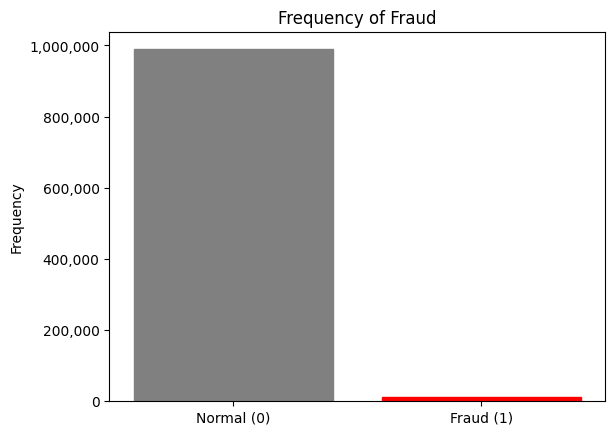

In [8]:
fig, ax = plt.subplots()
g = sns.countplot(df, x='fraud_bool', ax = ax)
ax.patches[1].set_color('red')
ax.patches[0].set_color('grey')
ax.set_xlabel('')
ax.set_ylabel('Frequency')
ax.set_xticklabels(['Normal (0)', 'Fraud (1)'])
t = ax.set_title('Frequency of Fraud')
ytlbls = ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
print('~ 1% of fraud cases, 1 out of 100.')

Fraud Cases at top right edge


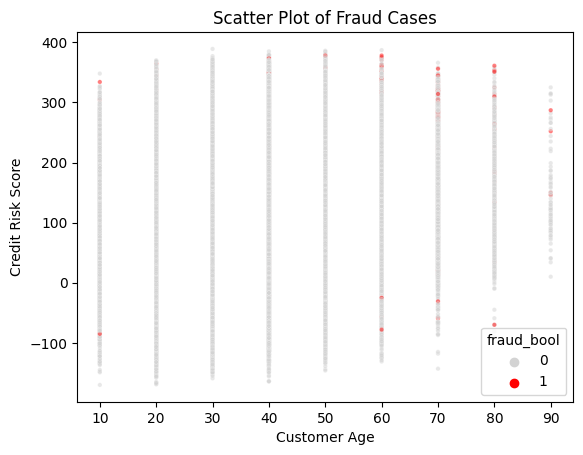

In [9]:
fig, ax = plt.subplots()
sns.scatterplot(x=df['customer_age'], y=df['credit_risk_score'], hue=df['fraud_bool'], ax=ax, 
                alpha=0.5, s=10, palette=sns.color_palette(['lightgrey', 'red']))
xl=ax.set_xlabel('Customer Age')
xy=ax.set_ylabel('Credit Risk Score')
tt=ax.set_title('Scatter Plot of Fraud Cases')
print('Fraud Cases at top right edge')

## Models ##
1. LEVEL 0 : Nil
2. LEVEL 1: Weights, Sampling

## Level 0: Logistic Regression ##

,value,Intepretation
0,0.000000,0.00% of all real fraud cases are detected.
1,0.000000,0.00% of all predicted cases are correct.
2,0.500000,50.00% of the time the model can distinguish positive from negative


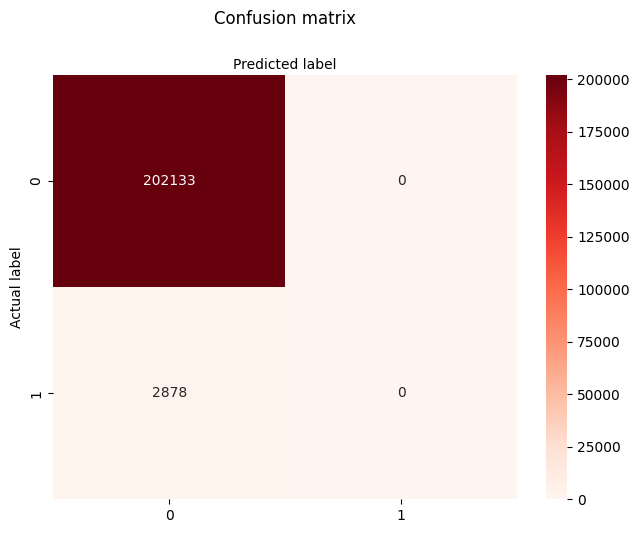

In [81]:
## Lvl 1 feature engineering, metric
basic_results = stratified_grid_search_cv(PARAMS, k=5, datax=processed_train_X, datay=train_y, weights='balanced')
c1 = basic_results['C'][0]

# Train
lg1 = LogisticRegression(random_state=SEED, class_weight=None, n_jobs=3, C=c1, max_iter=10000)
lg1.fit(processed_train_X, train_y)
# Test
processed_test_X = preprocess_x(test_X, enc, scaler)
test_probs1 = lg1.predict_proba(processed_test_X)
# Scoring
test_y_pred1 = test_probs1[:, 1] > THRESHOLD
result1 = scoring(test_y ,test_y_pred1)
with pd.option_context('display.max_rows', 5, 'display.max_colwidth', None):
    display(result1.style.apply(lambda x: ['color: red', 'color: red', 'color: red']))
# plot_roc_curve(test_y, test_y_pred1)
plot_confusion_matrix(test_y, test_y_pred1)


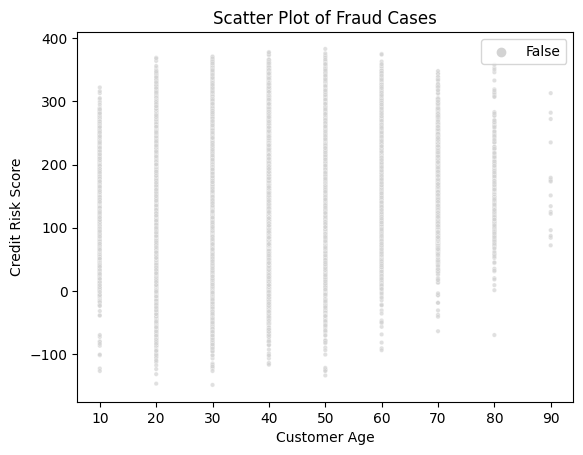

In [50]:
fig, ax = plt.subplots()
sns.scatterplot(x=test_X['customer_age'], y=test_X['credit_risk_score'], hue=test_y_pred1, ax=ax, 
                alpha=0.7, s=10, palette=sns.color_palette(['lightgrey', 'red']))
xl=ax.set_xlabel('Customer Age')
xy=ax.set_ylabel('Credit Risk Score')
tt=ax.set_title('Scatter Plot of Fraud Cases')

## Level 1 :  Logistic Regression + Sampling + Weights

,value,Intepretation
0,51.0100,51.01% of all real fraud cases are detected.
1,5.2400,5.24% of all predicted cases are correct.
2,0.6894,68.94% of the time the model can distinguish positive from negative


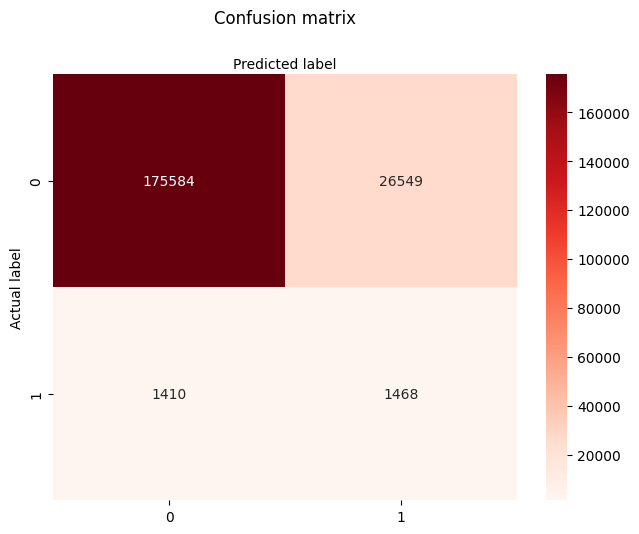

In [74]:
lvl2_results = stratified_grid_search_cv(PARAMS, k=5, datax=processed_train_X, datay=train_y)
c2 = lvl2_results['C'][0]

# Train
lg2 = LogisticRegression(random_state=SEED, class_weight='balanced', n_jobs=3, C=c2, max_iter=10000)
lg2.fit(X_res, y_res)

# Test
processed_test_X = preprocess_x(test_X, enc, scaler)
test_probs2= lg2.predict_proba(processed_test_X)
# Scoring
test_y_pred2 = test_probs2[:, 1] > THRESHOLD
result2 = scoring(test_y ,test_y_pred2)
with pd.option_context('display.max_rows', 5, 'display.max_colwidth', None):
    display(result2.style.apply(lambda x: ['color: green', 'color: green', 'color: green']))
# plot_roc_curve(test_y, test_y_pred2)
plot_confusion_matrix(test_y, test_y_pred2)

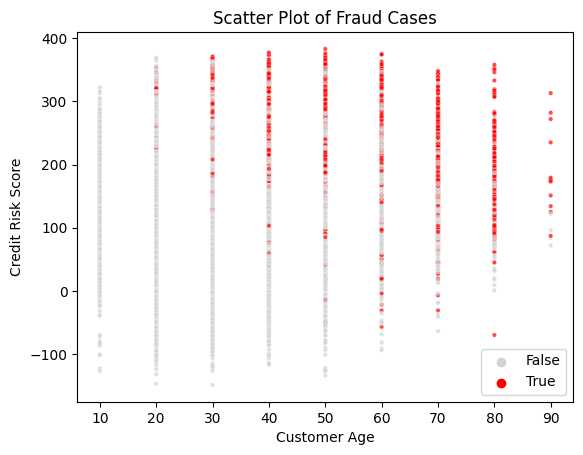

In [51]:
fig, ax = plt.subplots()
sns.scatterplot(x=test_X['customer_age'], y=test_X['credit_risk_score'], hue=test_y_pred2, ax=ax, 
                alpha=0.7, s=10, palette=sns.color_palette(['lightgrey', 'red']))
xl=ax.set_xlabel('Customer Age')
xy=ax.set_ylabel('Credit Risk Score')
tt=ax.set_title('Scatter Plot of Fraud Cases')

## Conclusion ##

In [80]:
print('No Imbalanced Methods')
with pd.option_context('display.max_rows', 5, 'display.max_colwidth', None):
    display(result1.style.apply(lambda x: ['color: red', 'color: red', 'color: red']))
print('With sampling and weights')
with pd.option_context('display.max_rows', 5, 'display.max_colwidth', None):
    display(result2.style.apply(lambda x: ['color: green', 'color: green', 'color: green']))

No Imbalanced Methods


,value,Intepretation
0,0.000000,0.00% of all real fraud cases are detected.
1,0.000000,0.00% of all predicted cases are correct.
2,0.500000,50.00% of the time the model can distinguish positive from negative


With sampling and weights


,value,Intepretation
0,51.010000,51.01% of all real fraud cases are detected.
1,5.240000,5.24% of all predicted cases are correct.
2,0.689400,68.94% of the time the model can distinguish positive from negative


## Feature importance of best model ##

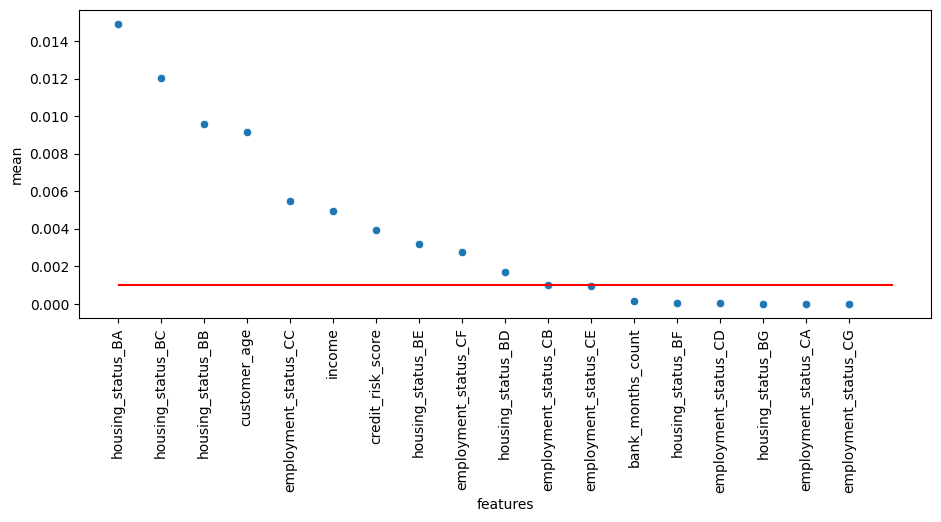

In [42]:
from sklearn.inspection import permutation_importance
r = permutation_importance(lg2_5, processed_train_X, train_y, n_repeats=30, random_state=SEED)
r_df = pd.DataFrame([processed_test_X.columns, np.abs(r.importances_mean), r.importances_std]).T
r_df.columns=['features', 'mean', 'std']
r_df = r_df.sort_values(by='mean', ascending=False)

# plot feature importance
fig, ax = plt.subplots(figsize=(11,4))
sns.scatterplot(data=r_df, x='features', y='mean', ax = ax)
ax.hlines(y=0.001, xmin=0, xmax=18, color='red')
ax.tick_params(axis='x', labelrotation=90)

